In [4]:
### Importing packages

import wbdata
import pandas as pd
import pandas_profiling
import datetime


In [92]:
### Inspecting Apis

wbdata.get_source()

1 	Doing Business
2 	World Development Indicators
3 	Worldwide Governance Indicators
5 	Subnational Malnutrition Database
6 	International Debt Statistics
11	Africa Development Indicators
12	Education Statistics
13	Enterprise Surveys
14	Gender Statistics
15	Global Economic Monitor
16	Health Nutrition and Population Statistics
18	IDA Results Measurement System
19	Millennium Development Goals
20	Quarterly Public Sector Debt
22	Quarterly External Debt Statistics SDDS
23	Quarterly External Debt Statistics GDDS
24	Poverty and Equity
25	Jobs
27	Global Economic Prospects
28	Global Financial Inclusion
29	The Atlas of Social Protection: Indicators of Resilience and Equity
30	Exporter Dynamics Database ��� Indicators at Country-Year Level
31	Country Policy and Institutional Assessment
32	Global Financial Development
33	G20 Financial Inclusion Indicators
34	Global Partnership for Education
35	Sustainable Energy for All
36	Statistical Capacity Indicators
37	LAC Equity Lab
38	Subnational Poverty
39

In [11]:
wbdata.get_indicator(source=15)

CORENS       	Core CPI,not seas.adj,,,
CORESA       	Core CPI,seas.adj,,,
CPTOTNSXN    	CPI Price, nominal
CPTOTSAXMZGY 	CPI Price, % y-o-y, median weighted, seas. adj.
CPTOTSAXN    	CPI Price, nominal, seas. adj.
CPTOTSAXNZGY 	CPI Price, % y-o-y, nominal, seas. adj.
DMGSRMRCHNSCD	Imports Merchandise, Customs, current US$, millions
DMGSRMRCHNSKD	Imports Merchandise, Customs, constant US$, millions
DMGSRMRCHNSXD	Imports Merchandise, Customs, Price, US$
DMGSRMRCHSACD	Imports Merchandise, Customs, current US$, millions, seas. adj.
DMGSRMRCHSAKD	Imports Merchandise, Customs, constant US$, millions, seas. adj.
DMGSRMRCHSAXD	Imports Merchandise, Customs, Price, US$, seas. adj.
DPANUSLCU    	Official exchange rate, LCU per USD, period average
DPANUSSPB    	Exchange rate, new LCU per USD extended backward, period average
DPANUSSPF    	Exchange rate, old LCU per USD extended forward, period average
DSTKMKTXD    	Stock Markets, US$
DSTKMKTXN    	Stock Markets, LCU
DXGSRMRCHNSCD	Exports Merchandi

In [6]:
wbdata.search_countries("united")

ARE	United Arab Emirates
GBR	United Kingdom
USA	United States


### Getting variables from World Bank API

Economic Growth
Prospects 20%

GDP per capita, real GDP volatility, real GDP average (5y), WEF
competitiveness, savings as a share of GDP, trade openness,
unemployment rate, 

Quality of Institutions 20%
rule of law, control of corruption, government effectiveness, regulatory
quality, voice and accountability, political stability, quality of statistics,

Monetary Stability 10% CPI average (5y), CPI volatility, domestic credit to GDP, real interest rate,

Fiscal & Public Debt 20% fiscal balance, government revenue efficiency, interest payments to tax
revenues, government debt to GDP, government external debt to GDP,

Balance of Payments
Flexibility 10% current account balance average (3y), export growth average (3y)

External Debt
Sustainability 10%

short-term to long-term external debt, foreign currency external debt to
total, net external debt to GDP, net external debt to exports, short-term
debt to FX reserves, interest payments on external debt to exports,
imports to FX reserves, external financing requirements to FX reserves,
interest payments on external debt to exports,

Private Sector 10% non-performing loan ratio, regulatory capital to risk weighted assets,
return on equity (banks), liquid assets to short-term liabilities (banks)

In [64]:
### Creating dictionary of variables 

dictionary = dict([('NYGDPMKTPKDZ','Annual GDP Growth 2010'), 
                   ('CC.EST','Control of Corruption Estimate'),
               ('RL.EST'    ,  'Rule of Law: Estimate'),
               ('RQ.EST'    ,   'Regulatory Quality: Estimate'),
               ('VA.EST'    ,   'Voice and Accountability: Estimate'),
              (' PV.EST'    ,   'Political Stability and Absence of Violence/Terrorism: Estimate'),
                  ('CORENS'       ,'Core CPI,not seas.adj'),
                ('CORESA'        ,'Core CPI,seas.adj'),
                ('CPTOTNSXN'    ,'CPI Price, nominal'),
                ('CPTOTSAXMZGY' ,'CPI Price, % y-o-y, median weighted, seas. adj.'),
                ('CPTOTSAXN'    ,'CPI Price, nominal, seas. adj.'),
                ('CPTOTSAXNZGY' ,'CPI Price, % y-o-y, nominal, seas. adj.'),
                ('DMGSRMRCHNSCD','Imports Merchandise, Customs, current US$, millions'),
                ('DMGSRMRCHNSKD','Imports Merchandise, Customs, constant US$, millions'),
                ('DMGSRMRCHNSXD','Imports Merchandise, Customs, Price, US$'),
                ('DMGSRMRCHSACD','Imports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DMGSRMRCHSAKD','Imports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DMGSRMRCHSAXD','Imports Merchandise, Customs, Price, US$, seas. adj.'),
                ('DPANUSLCU'    ,'Official exchange rate, LCU per USD, period average'),
                ('DPANUSSPB'    ,'Exchange rate, new LCU per USD extended backward, period average'),
                ('DPANUSSPF'    ,'Exchange rate, old LCU per USD extended forward, period average'),
                ('DSTKMKTXD'    ,'Stock Markets, US$'),
                ('DSTKMKTXN'    ,'Stock Markets, LCU'),
                ('DXGSRMRCHNSCD' ,'Exports Merchandise, Customs, current US$, millions'),
                ('DXGSRMRCHNSKD' ,'Exports Merchandise, Customs, constant US$, millions'),
                ('DXGSRMRCHNSXD' ,'Exports Merchandise, Customs, Price, US$'),
                ('DXGSRMRCHSACD' , 'Exports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DXGSRMRCHSAKD' ,'Exports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DXGSRMRCHSAXD' ,'Exports Merchandise, Customs, Price, US$, seas. adj.'),
                ('EMBIG'        ,'J.P. Morgan Emerging Markets Bond Spread (EMBI+'),
                ('EMBIGI'       ,'J.P. Morgan Emerging Markets Bond Index(EMBI+'),
                ('IMPCOV'       ,'Foreign Reserves, Months Import Cover, Goods'),
                ('IPTOTNSKD'    ,'Industrial Production, constant US$'),
                ('IPTOTSAKD'    ,'Industrial Production, constant US$, seas. adj.'),
                ('NEER'         ,'Nominal Effecive Exchange Rate'),
                ('NYGDPMKTPSACD' ,'GDP,current US$,millions,seas. adj.'),
                ('NYGDPMKTPSACN' ,'GDP,current LCU,millions,seas. adj.'),
                ('NYGDPMKTPSAKD' ,'GDP,constant 2010 US$,millions,seas. adj.'),
                ('NYGDPMKTPSAKN' ,'GDP,constant 2010 LCU,millions,seas. adj.'),
                ('REER'          ,'Real Effective Exchange Rate'),
                ('RETSALESSA'    ,'Retail Sales Volume,Index,'),
                ('TOT'           ,'Terms of Trade'),
                ('TOTRESV'       ,'Total Reserves'),
                ('UNEMPSA_'      ,'Unemployment rate,Percent')
                  ])

In [66]:
### Testing Dictionary 

dictionary['TOT']

'Terms of Trade'

In [14]:
### Building dataframe from APIs

datinho = wbdata.get_data('PV.EST', country="all", pandas = True) 
datinho.head()

country      date
Afghanistan  2017   -2.780772
             2016   -2.671054
             2015   -2.571222
             2014   -2.411068
             2013   -2.519349
Name: value, dtype: float64

In [5]:
### structuring dates 

data_dates = (datetime.datetime(2001,1,1), datetime.datetime(2015,1,1))

In [54]:
### Creating indicator to input into api

indicator={'IMPCOV':'Foreign Reserves',
       'IPTOTSAKD':'Industrial Production',
       'NYGDPMKTPSAKD':'GDP,constant 2010',
       'CORESA':'Core CPI',
       'RL.EST':'Rule of Law: Estimate',
       'PV.EST':'Political Stability and Absence of Violence/Terrorism: Estimate',
       'NEER':'Nominal Effecive Exchange Rate',
       'DSTKMKTXD':'Stock Markets USD',
       'EMBIG':'J.P. Morgan Emerging Markets Bond Spread'
    }

In [55]:
### Building dataframe from APIs

df=wbdata.get_dataframe(indicator,country='all')

In [56]:
# inspecting dataframe
df.head()

Foreign Reserves  Industrial Production  \
country            date                                            
Advanced Economies 1987               NaN                    NaN   
                   1988               NaN                    NaN   
                   1989               NaN                    NaN   
                   1990               NaN                    NaN   
                   1991          0.232183           7.186165e+12   

                         GDP,constant 2010   Core CPI  Rule of Law: Estimate  \
country            date                                                        
Advanced Economies 1987       2.537671e+07  56.117876                    NaN   
                   1988       2.660831e+07  58.304588                    NaN   
                   1989       2.765369e+07  60.852758                    NaN   
                   1990       2.845964e+07  63.721509                    NaN   
                   1991       2.883952e+07  66.584499                    NaN   

                         Political Stability and Absence of Violence/Terrorism: Estimate  \
country            date                                                                    
Advanced Economies 1987                                                NaN                 
                   1988                                                NaN                 
                   1989                                                NaN                 
                   1990                                                NaN                 
                   1991                                                NaN                 

                         Nominal Effecive Exchange Rate  Stock Markets USD  \
country            date                                                      
Advanced Economies 1987                       76.776320                NaN   
                   1988                       78.932198                NaN   
                   1989                       82.927398                NaN   
                   1990                       86.575677                NaN   
                   1991                       88.445536                NaN   

                         J.P. Morgan Emerging Markets Bond Spread  
country            date                                            
Advanced Economies 1987                                       NaN  
                   1988                                       NaN  
                   1989                                       NaN  
                   1990                                       NaN  
                   1991                                       NaN

In [57]:
data = df.reset_index()


In [58]:
data.head()

,country,date,Foreign Reserves,Industrial Production,"GDP,constant 2010",Core CPI,Rule of Law: Estimate,Political Stability and Absence of Violence/Terrorism: Estimate,Nominal Effecive Exchange Rate,Stock Markets USD,J.P. Morgan Emerging Markets Bond Spread
0,Advanced Economies,1987,NaN,NaN,2.537671e+07,56.117876,NaN,NaN,76.776320,NaN,NaN
1,Advanced Economies,1988,NaN,NaN,2.660831e+07,58.304588,NaN,NaN,78.932198,NaN,NaN
2,Advanced Economies,1989,NaN,NaN,2.765369e+07,60.852758,NaN,NaN,82.927398,NaN,NaN
3,Advanced Economies,1990,NaN,NaN,2.845964e+07,63.721509,NaN,NaN,86.575677,NaN,NaN
4,Advanced Economies,1991,0.232183,7.186165e+12,2.883952e+07,66.584499,NaN,NaN,88.445536,NaN,NaN


In [59]:
#### Profiling dataframe 

data.profile_report(style={'full_width':True})

In [13]:
def country_data(country_code, indicator, start = 2000, end = 2015):
    import datetime 
    import wbdata
    data_dates =  (datetime.datetime(start,1,1), datetime.datetime(end,1,1))
    #call the api
    data = wbdata.get_dataframe({indicator:'indicator'},
                               country=country_code,
                               data_date = data_dates,
                               convert_date = True,
                               keep_levels = False)
    data = data.reset_index()
    # data = data.dropna()# if I want i can drop the na´s
    return data[['indicator']]

In [14]:
country_data('IDN','EN.ATM.CO2E.PP.GD.KD')

,indicator
0,NaN
1,0.181880
2,0.201705
3,0.276695
4,0.277992
5,0.209629
6,0.231842
7,0.226354
8,0.216339
9,0.211427


Now it is time to write a grand function that takes as input a list of country codes, then uses our function above country_data to get a list of indicators for each country, then plot a line diagram.

In [18]:
#### creating function to plot indicators. 

def plot_indicators(country_list, indicator, start = 2000, end = 2015):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wbdata
    import re
    ind = wbdata.get_indicator(indicator, display = False)
    # capture the title which includes the unit after bracket
    title = ind[0]['name']
    # now take entire text from first letter to before opening bracket
    title = title[:title.find('(')-1]
    # this is the pattern to match anything between brackets
    p = re.compile('\((.*?)\)')
    ylab = p.findall(ind[0]['name'])[0]
    sns.set_style('white')
    fig, axis = plt.subplots()
    for c in country_list:
        axis.plot(range(start,end+1), country_data(c,indicator,start,end))
    plt.legend(country_list)
    plt.title(title)
    plt.ylabel(ylab)
    plt.show()

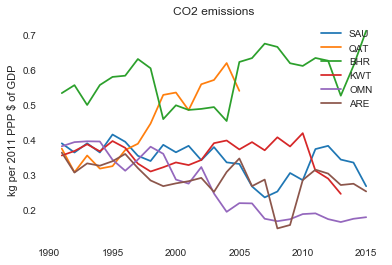

In [19]:
plot_indicators(['SAU','QAT','BHR','KWT','OMN','ARE'], 'EN.ATM.CO2E.PP.GD.KD',1990,2015)

Second, I had to extract from the title of the indicator the unit which sits in between parenthesis. To do that I used regular expression. So, let me explain this point further.

You saw above how I got the name of the indicator which returned something like GDP per unit of energy use (constant 2011 PPP $ per kg of oil equivalent)

Note that the name of all World Bank indicators starts with the actual title of the indicator, followed by the unit in between parenthesis. So, how we can extract these two parts.

Let us start with the first part which is easier. We want to start taking string subset from position 0 until we see the first opening bracket, that would be our title part. In order to do that, I used strings find() function as follows.

In [20]:
test_string = 'GDP per unit of energy use (constant 2011 PPP $ per kg of oil equivalent)'
test_string[:test_string.find('(')-1]

'GDP per unit of energy use'

find returns be the position of '(', so I take the string from position 0 to position of open bracket minus one (because the last character before bracket is a space which I want to ignore).

Now, the more difficult part is the unit which sits in between brackets. I could have used the same find() to search for index of closing bracket. But let me use regular expression so practice this powerful tool.

First we need to import regular expression package re. Then we need to design the pattern we are interested in which is anything in between open and close parenthesis. That is: '\((.*?)\)'. Check this stackoverflow post to get more information. I am using findall() function to return a list of all instances, and then I take the first instance of the list (at position 0).

In [21]:
import re
p = re.compile('\((.*?)\)')
p.findall('GDP per unit of energy use (constant 2011 PPP $ per kg of oil equivalent)')[0]

'constant 2011 PPP $ per kg of oil equivalent'

With these separation between title and unit, we can easily incorporate them in the ylabel and title of our matplotlib charts as done in our function above: plot_indicators.

In [15]:
### Data Wrangling 
datinho.describe()

count    3.901000e+03
mean    -8.715714e-10
std      9.976896e-01
min     -3.314937e+00
25%     -6.569121e-01
50%      1.203552e-01
75%      8.551208e-01
max      1.965062e+00
Name: value, dtype: float64

In [ ]:
### sensititivy analysis on thresholds 
### stationarity and non stationarity discussion 

In [ ]:
### build indicators


In [85]:
### Preparing machine learning pipeline 

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


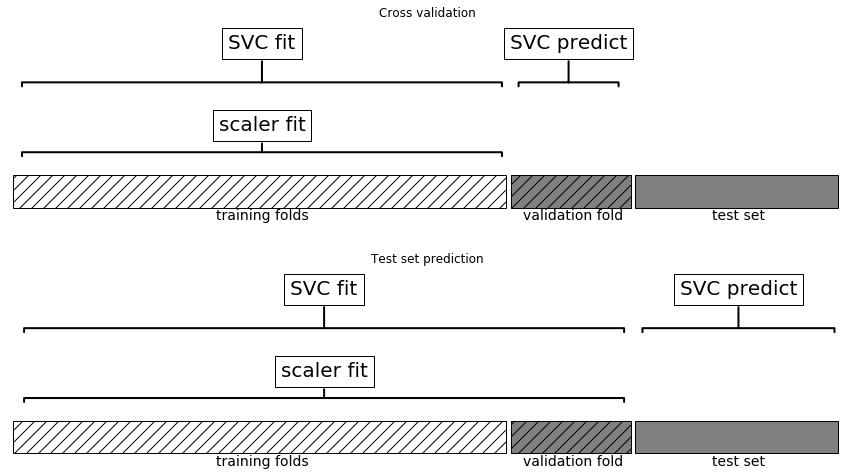

In [89]:
#### Describing what a ML pipeline looks like.

import mglearn 
mglearn.plots.plot_proper_processing()

In [102]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [103]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [104]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


In [105]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [106]:
pipe.fit(X_train, y_train)

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [107]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [108]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


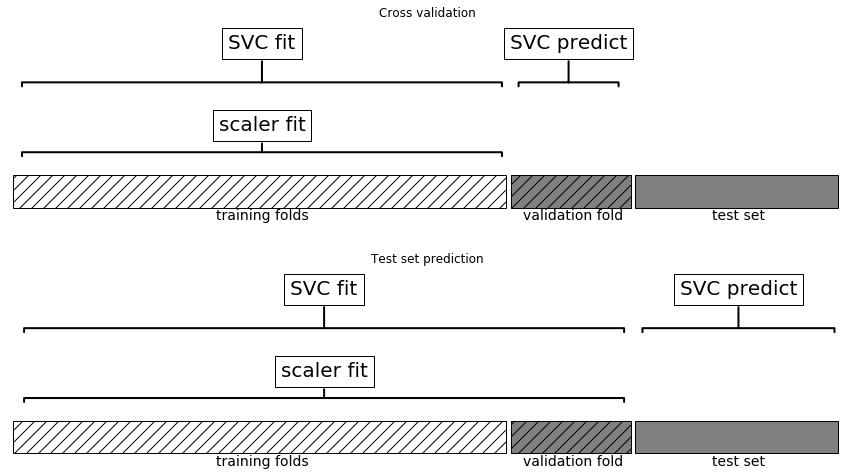

In [109]:
mglearn.plots.plot_proper_processing()